<a href="https://colab.research.google.com/github/toruuno/DNN_d3d4/blob/master/3_1_simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code_colab_lesson_3_4')
sys.path.append('/content/drive/My Drive/DNN_code_colab_lesson_3_4/lesson_3')
sys.path.append('/content/drive/My Drive/DNN_code_colab_lesson_3_4/common')
sys.path.append('/content/drive/My Drive/DNN_code_colab_lesson_3_4/data')

# simple RNN
### バイナリ加算

In [ ]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt
from enum import Enum

class act_func_name(Enum):
    sigmoid =1
    tanh = 2
    ReLU = 3

class init_mode(Enum):
    normal = 1 #正規分布
    Xavier = 2
    He = 3


def d_tanh(x):
    return 4/((np.exp(x) + np.exp(-x))**2)


def act_func(a_func, v, debug):
    if a_func == act_func_name.ReLU: 
        #if debug: print("ReLU func")
        return functions.relu(v)

    if a_func == act_func_name.tanh: 
        #if debug: print("tanh func")
        return np.tanh(v)

    #if debug: print("sigmoid func")
    return functions.sigmoid(v)

def d_act_func(a_func, v, debug):
    if a_func == act_func_name.ReLU: 
        #if debug: print("d_ReLU func")
        return functions.d_relu(v)

    if a_func == act_func_name.tanh: 
        #if debug: print("d_tanh func")
        return d_tanh(v)

    #if debug: print("d_sigmoid func")
    return functions.d_sigmoid(v)


def try_func(weight_init_std=1, learning_rate = 0.1, hidden_layer_size = 16, a_fnc=act_func_name.sigmoid, inimode=init_mode.normal,debug=True,plim=0):
    # データを用意
    # 2進数の桁数
    binary_dim = 8
    # 最大値 + 1
    largest_number = pow(2, binary_dim)
    # largest_numberまで2進数を用意
    binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

    input_layer_size = 2
    #hidden_layer_size = 16
    output_layer_size = 1

    #weight_init_std = 1
    #learning_rate = 0.1

    iters_num = 10000
    plot_interval = 100

    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("weight_init_std={}, learning_rate={}, hidden_layer_size={}".format(weight_init_std, learning_rate, hidden_layer_size))

    # ウェイト初期化 (バイアスは簡単のため省略)
    W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
    W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
    W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
    if inimode == init_mode.Xavier:
        #Xavier
        print("Xavier")
        W_in /= np.sqrt(input_layer_size)
        W_out /=  np.sqrt(hidden_layer_size)
        W /= np.sqrt(hidden_layer_size)
    elif inimode == init_mode.He:
        #He
        print("He")
        W_in /= np.sqrt(input_layer_size) * np.sqrt(2)
        W_out /= np.sqrt(hidden_layer_size) * np.sqrt(2)
        W /= np.sqrt(hidden_layer_size) * np.sqrt(2)
    else:
        #正規分布
        print("正規分布")

    print(a_fnc.name)

    print("------------")

    # 勾配
    W_in_grad = np.zeros_like(W_in)
    W_out_grad = np.zeros_like(W_out)
    W_grad = np.zeros_like(W)

    u = np.zeros((hidden_layer_size, binary_dim + 1))
    z = np.zeros((hidden_layer_size, binary_dim + 1))
    y = np.zeros((output_layer_size, binary_dim))

    delta_out = np.zeros((output_layer_size, binary_dim))
    delta = np.zeros((hidden_layer_size, binary_dim + 1))

    all_losses = []

    for i in range(iters_num):
        
        # A, B初期化 (a + b = d)
        a_int = np.random.randint(largest_number/2)
        a_bin = binary[a_int] # binary encoding
        b_int = np.random.randint(largest_number/2)
        b_bin = binary[b_int] # binary encoding
        
        # 正解データ
        d_int = a_int + b_int
        d_bin = binary[d_int]
        
        # 出力バイナリ
        out_bin = np.zeros_like(d_bin)
        
        # 時系列全体の誤差
        all_loss = 0    
        
        # 時系列ループ
        for t in range(binary_dim):
            # 入力値
            X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
            # 時刻tにおける正解データ
            dd = np.array([d_bin[binary_dim - t - 1]])
            
            u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
            z[:,t+1] = act_func(a_fnc, u[:,t+1], debug)

            y[:,t] = act_func(a_fnc, np.dot(z[:,t+1].reshape(1, -1), W_out), debug)


            #誤差
            loss = functions.mean_squared_error(dd, y[:,t])
            
            delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * d_act_func(a_fnc, y[:,t], debug)        
            
            all_loss += loss

            out_bin[binary_dim - t - 1] = np.round(y[:,t])
        
        
        for t in range(binary_dim)[::-1]:
            X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

            delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_act_func(a_fnc, u[:,t+1], debug)

            # 勾配更新
            W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
            W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
            W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
        
        # 勾配適用
        W_in -= learning_rate * W_in_grad
        W_out -= learning_rate * W_out_grad
        W -= learning_rate * W_grad
        
        W_in_grad *= 0
        W_out_grad *= 0
        W_grad *= 0
        

        if(i % plot_interval == 0):
            all_losses.append(all_loss)        
            if debug: print("iters:" + str(i))
            if debug: print("Loss:" + str(all_loss))
            if debug: print("Pred:" + str(out_bin))
            if debug: print("True:" + str(d_bin))
            out_int = 0
            for index,x in enumerate(reversed(out_bin)):
                out_int += x * pow(2, index)
            if debug: print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
            if debug: print("------------")

    lists = range(0, iters_num, plot_interval)
    plt.plot(lists, all_losses, label="loss")
    if plim!=0: plt.ylim(0,plim)
    plt.grid()
    plt.show()

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=0.1, hidden_layer_size=16
正規分布
sigmoid
------------
iters:0
Loss:1.4875273098025743
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 0 1 1 1 0 0]
73 + 19 = 255
------------
iters:100
Loss:1.0443469335309512
Pred:[1 0 0 0 0 0 1 0]
True:[0 1 1 0 0 0 0 1]
64 + 33 = 130
------------
iters:200
Loss:0.9264198676863292
Pred:[0 0 0 0 0 0 0 0]
True:[1 1 0 0 1 0 0 0]
89 + 111 = 0
------------
iters:300
Loss:1.0257646511373382
Pred:[0 1 1 1 1 0 1 1]
True:[1 0 0 1 0 0 0 1]
25 + 120 = 123
------------
iters:400
Loss:0.9763596216434711
Pred:[1 1 0 0 1 1 1 1]
True:[1 1 0 1 0 0 0 1]
99 + 110 = 207
------------
iters:500
Loss:1.1907083304780002
Pred:[1 1 1 1 1 1 1 0]
True:[1 0 0 0 0 0 0 0]
61 + 67 = 254
------------
iters:600
Loss:0.8398121997072119
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 0 1 0 1 0 0]
4 + 16 = 0
------------
iters:700
Loss:0.8798012134280533
Pred:[0 0 0 0 0 0 0 1]
True:[1 0 0 0 0 1 1 0]
101 + 33 = 1
-------

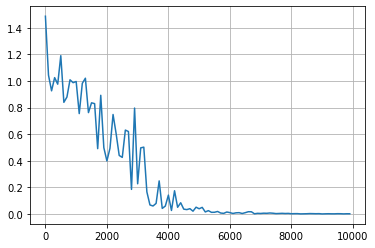

In [ ]:
#既定のハイパーパラメータで学習させておく(Logを残す)
try_func()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] weight_init_stdやlearning_rate, hidden_layer_sizeを変更してみよう


## [try] 重みの初期化方法を変更してみよう
Xavier, He

## [try] 中間層の活性化関数を変更してみよう
ReLU(勾配爆発を確認しよう)<br>
tanh(numpyにtanhが用意されている。導関数をd_tanhとして作成しよう)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1.5, learning_rate=0.1, hidden_layer_size=16
正規分布
sigmoid
------------


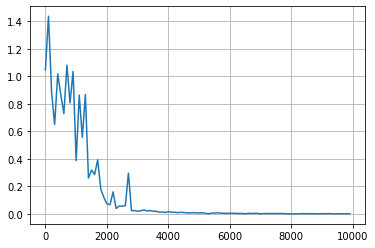

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=0.1, hidden_layer_size=16
正規分布
sigmoid
------------


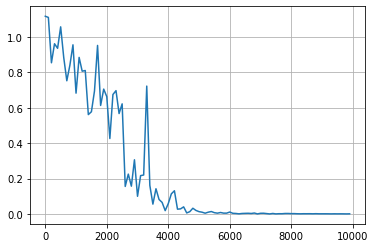

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=0.1, learning_rate=0.1, hidden_layer_size=16
正規分布
sigmoid
------------


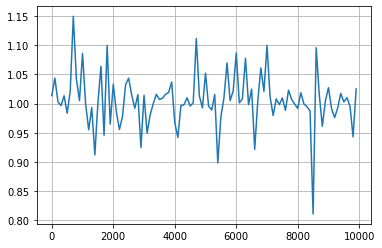

In [ ]:
# weight_init_stdを変更
try_func(weight_init_std=1.5,debug=False)
try_func(debug=False)
try_func(weight_init_std=0.1,debug=False)

#デフォルト値位が無難そう

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=0.01, hidden_layer_size=16
正規分布
sigmoid
------------


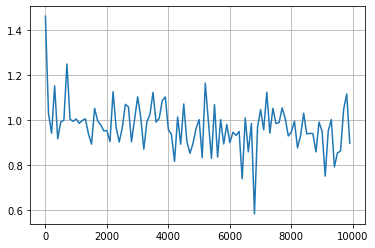

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=0.1, hidden_layer_size=16
正規分布
sigmoid
------------


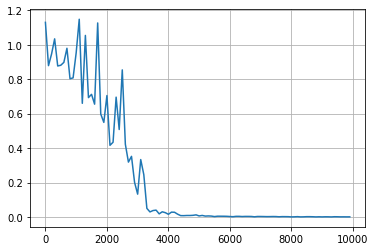

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=1, hidden_layer_size=16
正規分布
sigmoid
------------


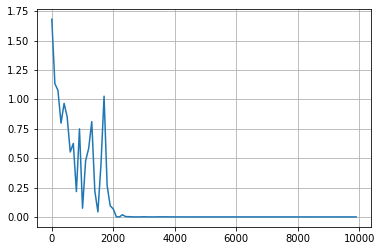

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=5, hidden_layer_size=16
正規分布
sigmoid
------------


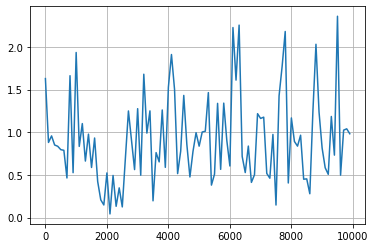

In [ ]:
# learning_rateを変更
try_func(learning_rate=0.01,debug=False)
try_func(debug=False)
try_func(learning_rate=1,debug=False)
try_func(learning_rate=5,debug=False)


#デフォルト値からチューニングの余地はありそう(少し増やす)

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=0.1, hidden_layer_size=32
正規分布
sigmoid
------------


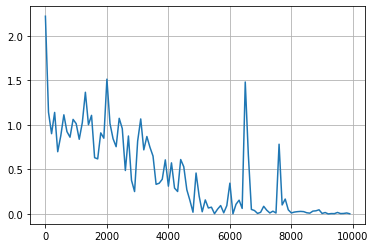

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=0.1, hidden_layer_size=16
正規分布
sigmoid
------------


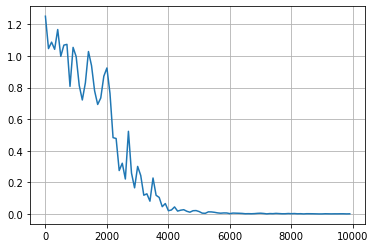

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=0.1, hidden_layer_size=8
正規分布
sigmoid
------------


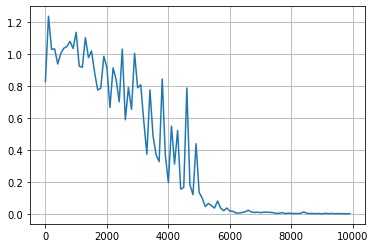

In [ ]:
# hidden_layer_sizeを変更
try_func(hidden_layer_size=32,debug=False)
try_func(debug=False)
try_func(hidden_layer_size=8,debug=False)

#デフォルト値からチューニングの余地はありそう(少し増やす)

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=0.1, hidden_layer_size=16
正規分布
sigmoid
------------


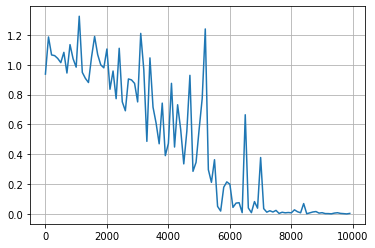

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=0.1, hidden_layer_size=16
Xavier
sigmoid
------------


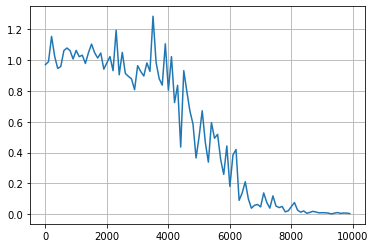

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=0.1, hidden_layer_size=16
He
sigmoid
------------


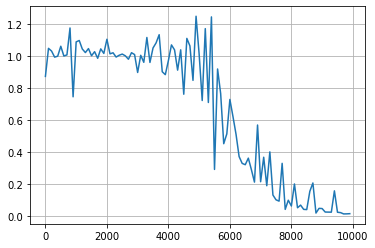

In [ ]:
#重みの初期化方法を変更
try_func(inimode=init_mode.normal,debug=False)
try_func(inimode=init_mode.Xavier,debug=False)
try_func(inimode=init_mode.He,debug=False)

#RNNの場合、正規分布で初期化した方が安定する様である

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=0.1, hidden_layer_size=16
正規分布
sigmoid
------------


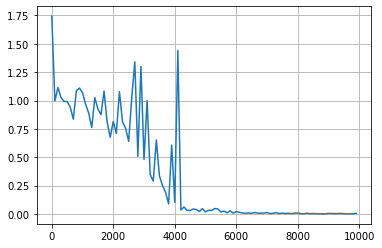

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=0.1, hidden_layer_size=16
正規分布
ReLU
------------


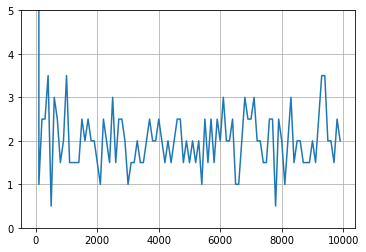

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
weight_init_std=1, learning_rate=0.1, hidden_layer_size=16
正規分布
tanh
------------


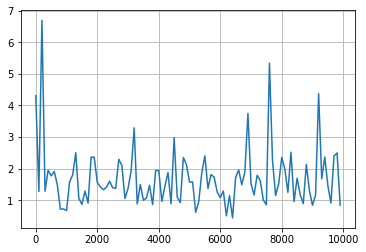

In [ ]:
#活性化関数を変更
try_func(debug=False)
try_func(a_fnc=act_func_name.ReLU,debug=False,plim=5)  #勾配爆発の影響で瞬時誤差が数万に達する場合もあるので可視化の為スケール制限
try_func(a_fnc=act_func_name.tanh,debug=False)


#sigmoid関数を省き、学習は収束しない(誤差が無くならない)